In [247]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pylab as plt


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# data load & 전처리

### train data

In [371]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [372]:
df_date_x = df_merge['date_x'].copy()
df_date_y = df_merge['date_y'].copy()

In [373]:
df_merge.drop(['date_x', 'date_y'], axis=1, inplace=True)

In [374]:
idx1 = df_merge.activity_id[df_merge.activity_id.str.contains('^act1')].index
idx2 = df_merge.activity_id[df_merge.activity_id.str.contains('^act2')].index
df_merge.activity_id.loc[idx1] = 1
df_merge.activity_id.loc[idx2] = 2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [375]:
df_merge = df_merge.replace('ppl_', '', regex=True).apply(pd.to_numeric, errors='ignore')

MemoryError: 

In [ ]:
df_merge = df_merge.replace('group ', '', regex=True).apply(pd.to_numeric, errors='ignore')

In [ ]:
df_merge = df_merge.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

##### add Past days, week

In [ ]:
df_merge.insert(loc=2 ,column='date_x', value=df_date_x)
# df_merge.insert(loc=3 ,column='Past days_x', value=(df_merge['date_x'] - pd._libs.tslib.Timestamp('2022-07-17 00:00:00')))
df_merge.insert(loc=3 ,column='week_x', value=df_merge['date_x'].dt.weekday)
# df_merge.insert(loc=3 ,column='date_year_x', value=df_date_x.dt.year)
# df_merge.insert(loc=4 ,column='date_month_x', value=df_date_x.dt.month)
# df_merge.insert(loc=5 ,column='date_day_x', value=df_date_x.dt.day)
# df_merge['Past days_x']=(pd.to_numeric(df_merge['Past days_x'])/86400000000000).astype(int)

df_merge.insert(loc=18 ,column='date_y', value=df_date_y)
# df_merge.insert(loc=19 ,column='Past days_y', value=(df_merge['date_y'] - pd._libs.tslib.Timestamp('2020-05-18 00:00:00')))
df_merge.insert(loc=19 ,column='week_y', value=df_merge['date_y'].dt.weekday)
# df_merge.insert(loc=19 ,column='date_year_y', value=df_date_y.dt.year)
# df_merge.insert(loc=20 ,column='date_month_y', value=df_date_y.dt.month)
# df_merge.insert(loc=21 ,column='date_day_y', value=df_date_y.dt.day)
# df_merge['Past days_y']=(pd.to_numeric(df_merge['Past days_y'])/86400000000000).astype(int)

df_merge.insert(loc=4 ,column='Past days', value=(df_merge.date_x - df_merge.date_y).astype('timedelta64[D]'))

### test data

In [ ]:
# df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
# df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')
# df_date_x_test = df_merge_test['date_x'].copy()
# df_date_y_test = df_merge_test['date_y'].copy()

# df_merge_test.drop(['date_x', 'date_y'], axis=1, inplace=True)

# df_merge_test = df_merge_test.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

# idx1_test = df_merge_test.activity_id[df_merge_test.activity_id.str.contains('^act1')].index
# idx2_test = df_merge_test.activity_id[df_merge_test.activity_id.str.contains('^act2')].index
# df_merge_test.activity_id.loc[idx1_test] = 1
# df_merge_test.activity_id.loc[idx2_test] = 2

# df_merge_test.insert(loc=2 ,column='date_x', value=df_date_x_test)
# # df_merge_test.insert(loc=3 ,column='Past days_x', value=(df_merge_test['date_x'] - pd._libs.tslib.Timestamp('2022-07-17 00:00:00')))
# df_merge_test.insert(loc=3 ,column='week_x', value=df_merge_test['date_x'].dt.weekday)
# # df_merge_test.insert(loc=3 ,column='date_year_x', value=df_date_x_test.dt.year)
# # df_merge_test.insert(loc=4 ,column='date_month_x', value=df_date_x_test.dt.month)
# # df_merge_test.insert(loc=5 ,column='date_day_x', value=df_date_x_test.dt.day)

# df_merge_test.insert(loc=18 ,column='date_y', value=df_date_y_test)
# # df_merge_test.insert(loc=19 ,column='Past days_y', value=(df_merge_test['date_y'] - pd._libs.tslib.Timestamp('2020-05-18 00:00:00')))
# df_merge_test.insert(loc=19 ,column='week_y', value=df_merge_test['date_y'].dt.weekday)
# # df_merge_test.insert(loc=19 ,column='date_year_y', value=df_date_y_test.dt.year)
# # df_merge_test.insert(loc=20 ,column='date_month_y', value=df_date_y_test.dt.month)
# # df_merge_test.insert(loc=21 ,column='date_day_y', value=df_date_y_test.dt.day)
# df_merge_test['past days'] = (df_merge_test.date_x - df_merge_test.date_y).astype('timedelta64[D]')

In [20]:
del df_train, df_people, df_date_x, df_date_y, idx1, idx2
# del df_test, df_date_x_test, df_date_y_test, idx1_test, idx2_test

In [ ]:
# df_merge.to_csv("train_merge.csv")

In [ ]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])

In [ ]:
df_merge.head()

# EDA

In [24]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [58]:
df_merge.describe()

,activity_id,week_x,Past days,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,char_1_y,week_y,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_38
count,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,157615.000000,2.039676e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06
mean,1.928268e+00,3.231972e+00,2.593235e+02,2.997433e+00,6.932449,5.188389,3.932145,2.799023,3.579881,2.010443,2.554275,5.275538,7.200761,5.038379e+02,4.439544e-01,1.906321e+00,3.142312e+00,2.448956e+00,1.786501e+01,1.223861e+01,5.760739e+00,2.744043e+00,1.077467e+01,3.093629e+00,3.476141e+00,4.998051e+01
std,2.580429e-01,1.558017e+00,2.748091e+02,1.314068e+00,6.923220,4.769402,2.150886,1.060304,2.261971,0.815512,1.575641,3.036524,4.936222,1.202242e+03,4.968491e-01,2.913810e-01,1.528937e+00,6.593571e-01,1.583957e+01,9.255424e+00,2.724680e+00,1.407350e+00,6.454917e+00,1.548692e+00,1.932350e+00,3.608557e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+00,1.700000e+01,2.000000e+00,2.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,4.000000,3.000000,1.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00,6.000000e+00,3.000000e+00,1.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00
50%,2.000000e+00,3.000000e+00,1.710000e+02,3.000000e+00,5.000000,3.000000,4.000000,3.000000,3.000000,2.000000,2.000000,4.000000,7.000000,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,1.000000e+01,7.000000e+00,5.000000e+00,3.000000e+00,9.000000e+00,3.000000e+00,3.000000e+00,5.900000e+01
75%,2.000000e+00,4.000000e+00,4.230000e+02,4.000000e+00,10.000000,6.000000,5.000000,3.000000,6.000000,3.000000,3.000000,6.000000,10.000000,4.500000e+02,1.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,4.000000e+01,2.500000e+01,9.000000e+00,4.000000e+00,1.600000e+01,3.000000e+00,4.000000e+00,8.200000e+01
max,2.000000e+00,6.000000e+00,1.197000e+03,7.000000e+00,52.000000,32.000000,11.000000,7.000000,7.000000,5.000000,8.000000,18.000000,19.000000,9.251000e+03,1.000000e+00,2.000000e+00,6.000000e+00,3.000000e+00,4.400000e+01,2.500000e+01,9.000000e+00,7.000000e+00,2.500000e+01,8.000000e+00,9.000000e+00,1.000000e+02


In [56]:
df_merge[['date_x', 'date_y']].describe()

,date_x,date_y
count,2197291,2197291
unique,411,1196
top,2022-09-30 00:00:00,2022-03-02 00:00:00
freq,48174,55371
first,2022-07-17 00:00:00,2020-05-18 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


In [313]:
df_merge.people_id.describe()

count        2197291
unique        151295
top       ppl_294918
freq           55103
Name: people_id, dtype: object

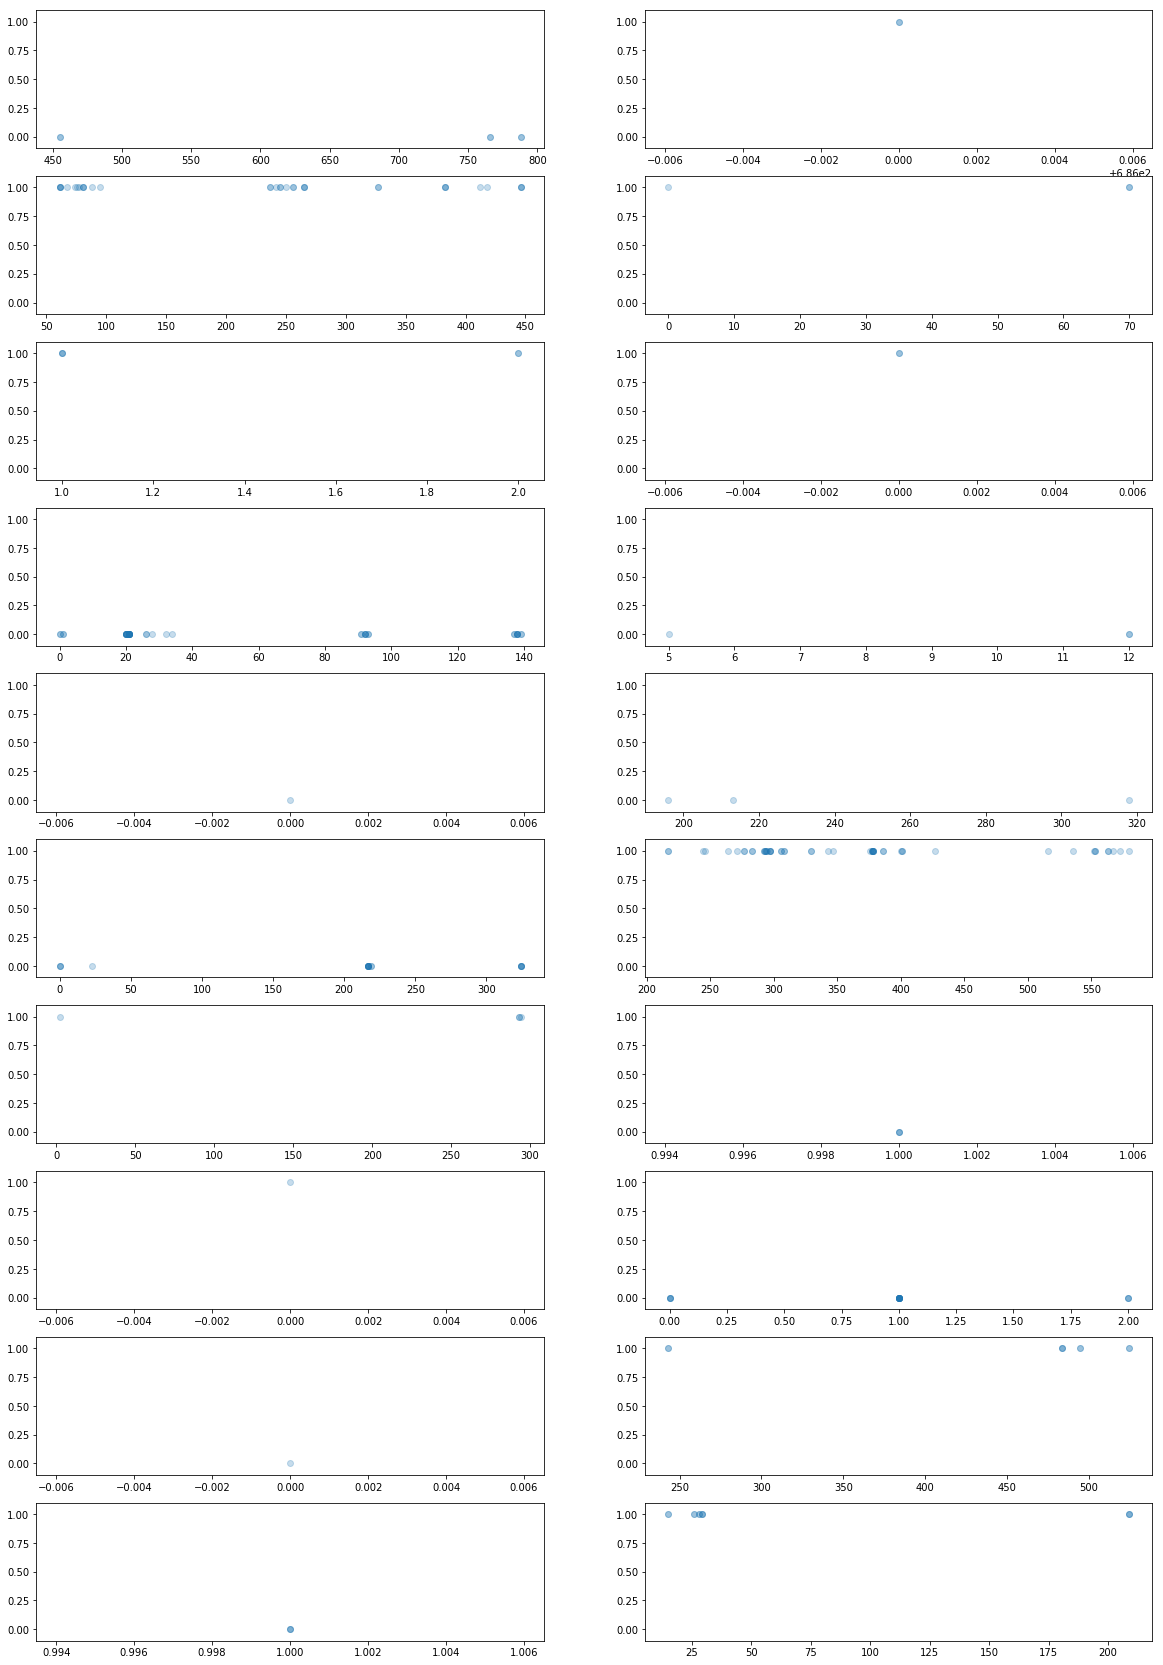

In [311]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == '{}'.format(ppl)]['Past days'], \
                df_merge[df_merge.people_id == '{}'.format(ppl)].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [364]:
df_merge.people_id.value_counts().head()

ppl_294918    55103
ppl_370270    53668
ppl_105739    45936
ppl_54699     23969
ppl_64887      7052
Name: people_id, dtype: int64

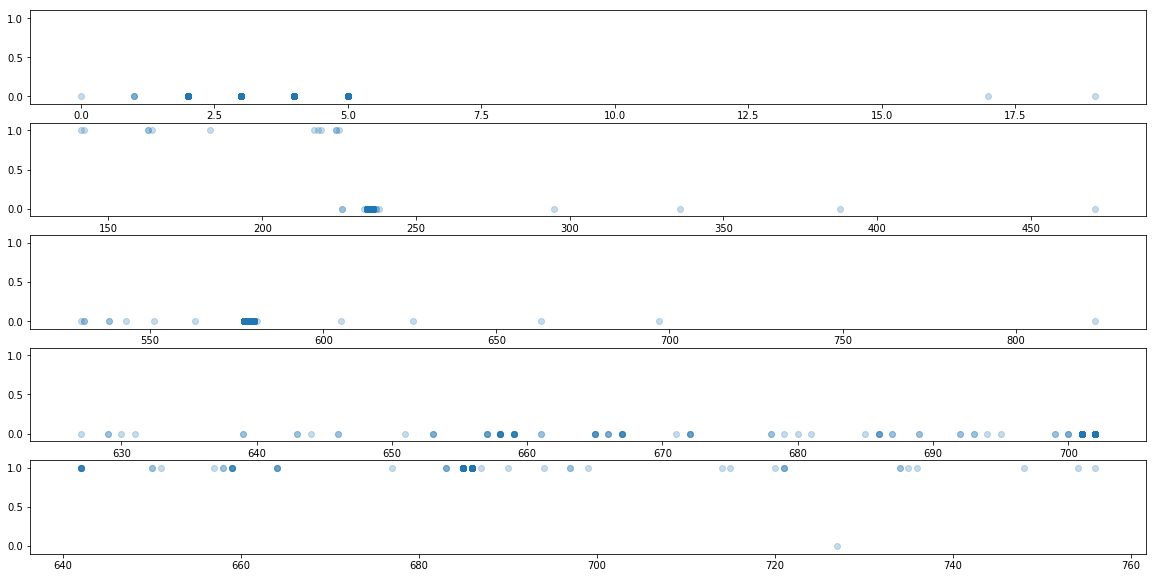

In [370]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, group in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == 'ppl_{}'.format(group)]['Past days'], \
                df_merge[df_merge.people_id == 'ppl_{}'.format(group)].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

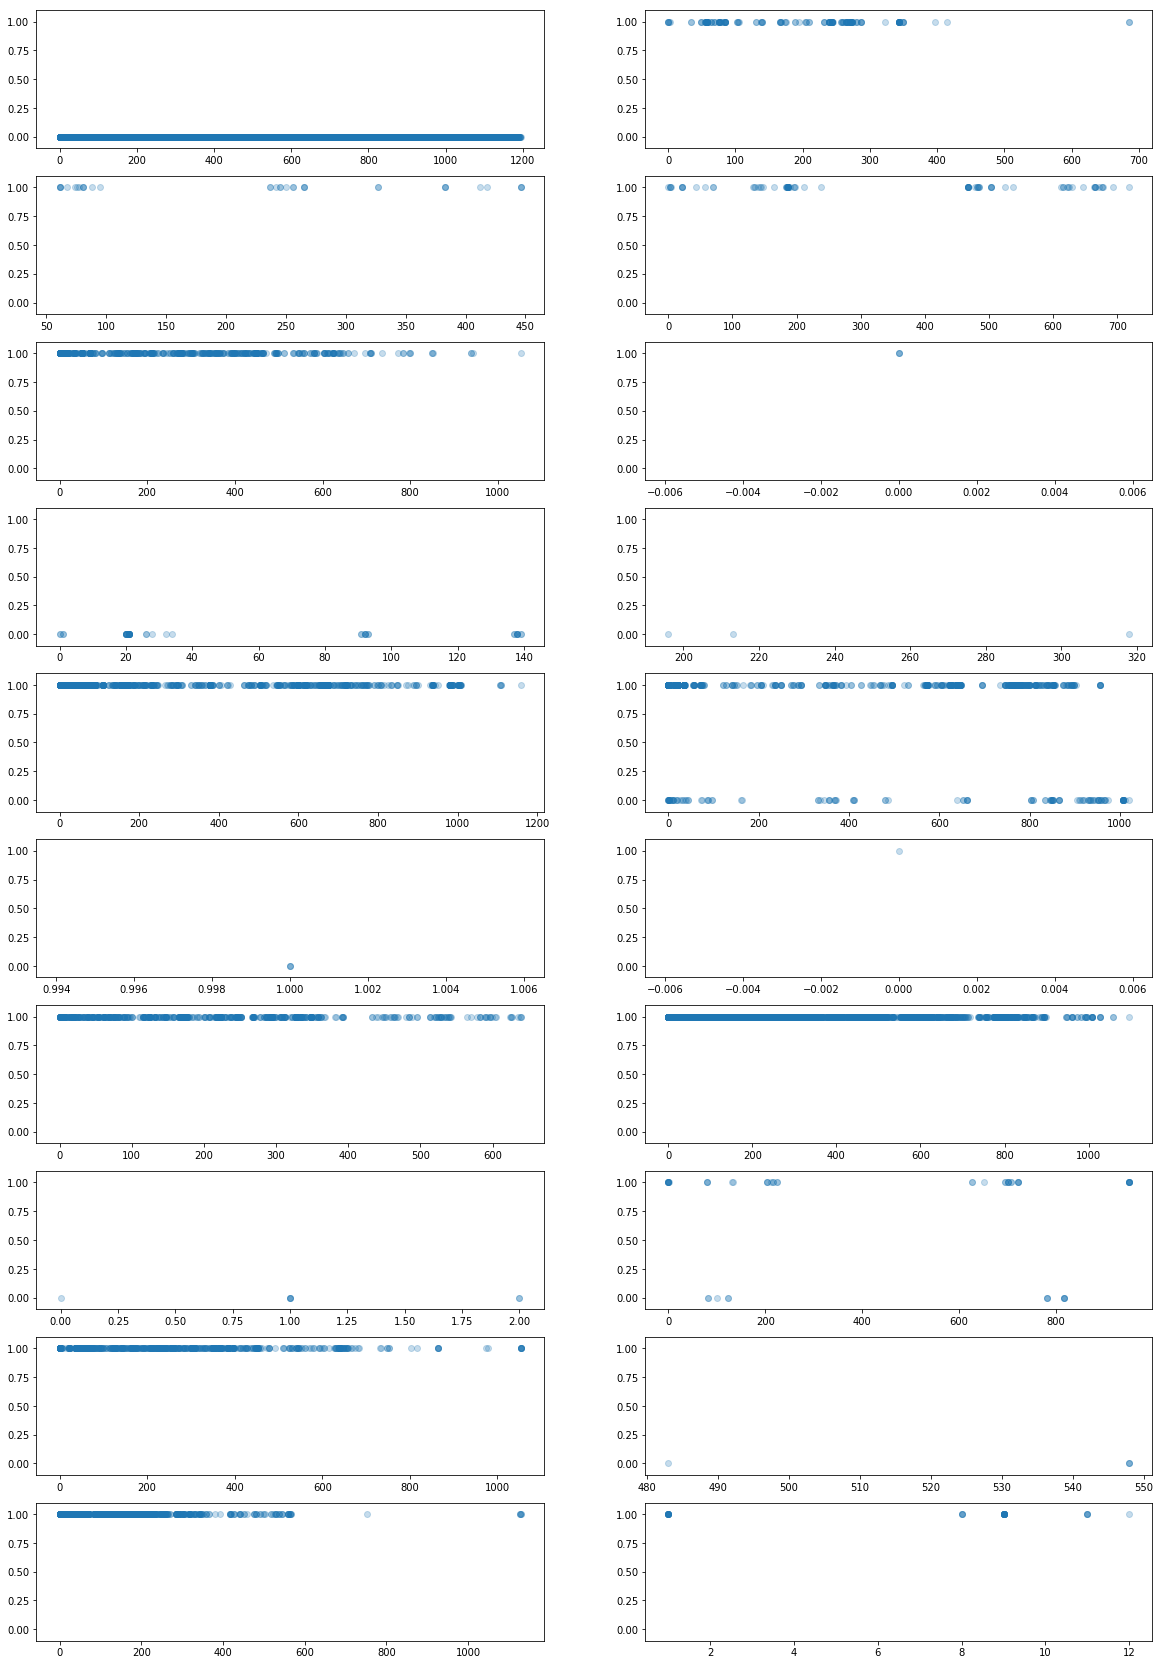

In [312]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == '{}'.format(group)]['Past days'], \
                df_merge[df_merge.group_1 == '{}'.format(group)].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

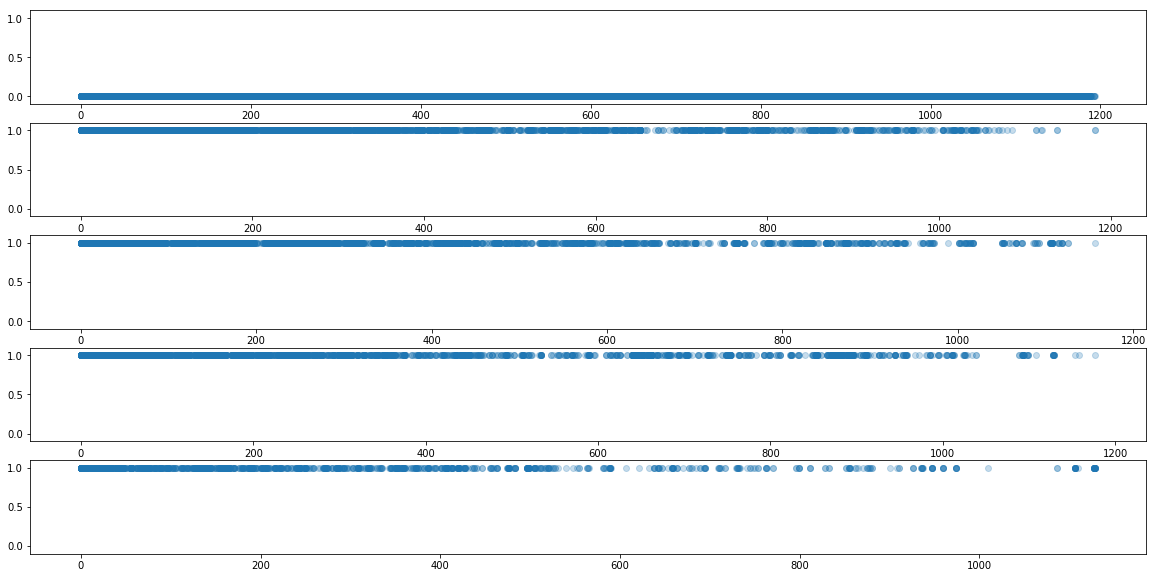

In [368]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == 'group {}'.format(group)]['Past days'], \
                df_merge[df_merge.group_1 == 'group {}'.format(group)].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

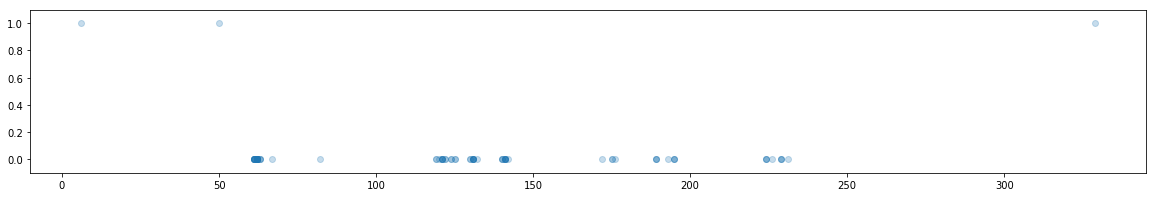

In [262]:
plt.figure(figsize=(20,3))
plt.scatter(df_ppl_ppl_170985['Past days'], df_ppl_ppl_170985.outcome, alpha = 0.25)
plt.ylim(-0.1,1.1)
plt.show()

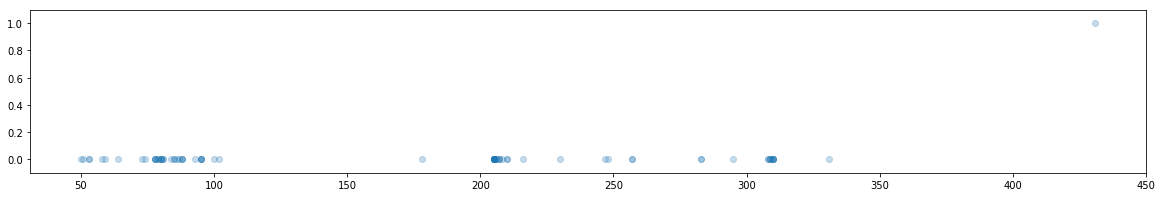

In [263]:
plt.figure(figsize=(20,3))
plt.scatter(df_ppl_ppl_384571['Past days'], df_ppl_ppl_384571.outcome, alpha = 0.25)
plt.ylim(-0.1,1.1)
plt.show()

#### sample

In [25]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()

In [34]:
df_sample.groupby(['activity_id', 'activity_category']).count()

people_id  date_x  week_x  Past days  char_1_x  \
activity_id activity_category                                                   
1           1                      15813   15813   15813      15813     15813   
2           2                      90498   90498   90498      90498         0   
            3                      42804   42804   42804      42804         0   
            4                      20891   20891   20891      20891         0   
            5                      48968   48968   48968      48968         0   
            6                        429     429     429        429         0   
            7                        326     326     326        326         0   

                               char_2_x  char_3_x  char_4_x  char_5_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_6_x  char_7_x  char_8_x  char_9_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_10_x  outcome  char_1_y  group_1  date_y  \
activity_id activity_category                                                  
1           1                          0    15813     15813    15813   15813   
2           2                      90498    90498     90498    90498   90498   
            3                      42804    42804     42804    42804   42804   
            4                      20891    20891     20891    20891   20891   
            5                      48968    48968     48968    48968   48968   
            6                        429      429       429      429     429   
            7                        326      326       326      326     326   

                               week_y  char_2_y  char_3_y  char_4_y  char_5_y  \
activity_id activity_category                                                   
1           1                   15813     15813     15813     15813     15813   
2           2                   90498     90498     90498     90498     90498   
            3                   42804     42804     42804     42804     42804   
            4                   20891     20891     20891     20891     20891   
            5                   48968     48968     48968     48968     48968   
            6                     429       429       429       429       429   
            7                     326       326       326       326       326   

                               char_6_y  char_7_y  char_8_y  char_9_y  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                     90498     90498     90498     90498   
            3                     42804     42804     42804     42804   
            4                     20891     20891     20891     20891   
            5                     48968     48968     48968     48968   
            6          

In [226]:
df_sample_0 = df_sample[df_sample.outcome==0].copy()
df_sample_1 = df_sample[df_sample.outcome==1].copy()

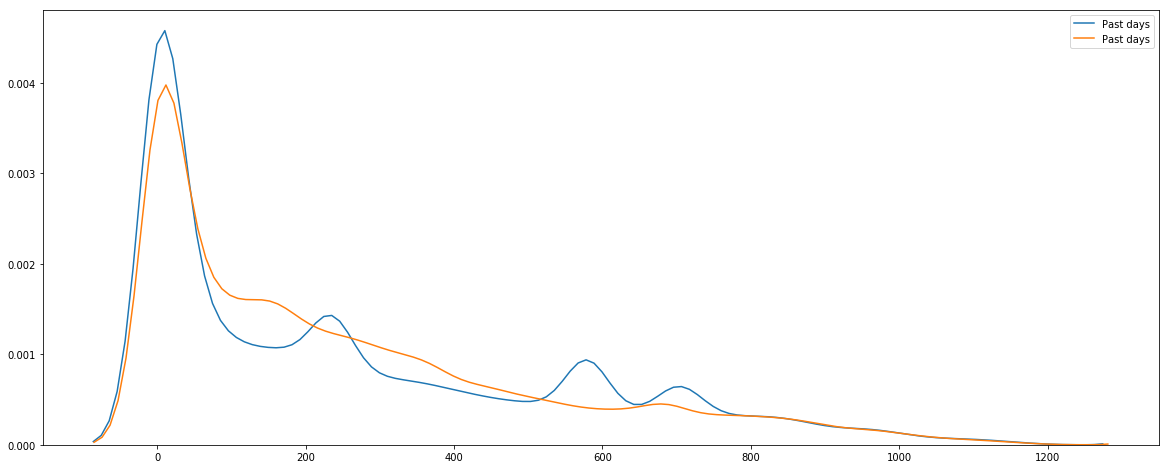

In [239]:
plt.figure(figsize=(20,8))
sns.kdeplot(df_sample_0['Past days'])
sns.kdeplot(df_sample_1['Past days'])
plt.show()

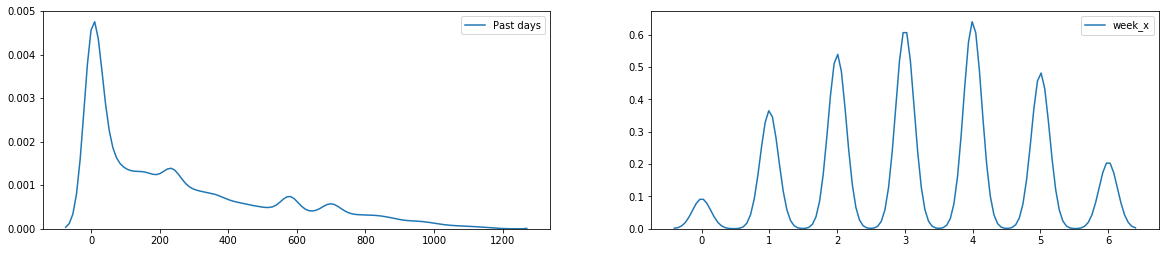

In [228]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.kdeplot(df_sample['Past days'])
plt.subplot(1,2,2)
sns.kdeplot(df_sample['week_x'])
plt.show()

#### char_1_x ~ char_9_x

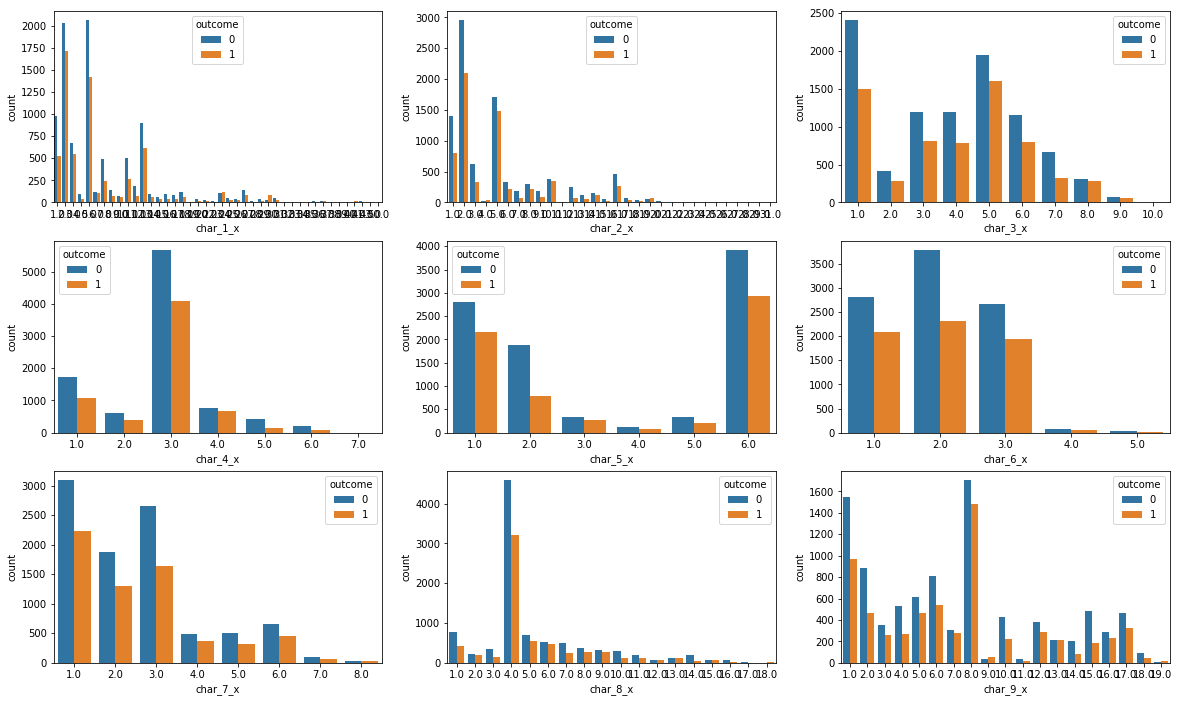

In [132]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[6:15]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

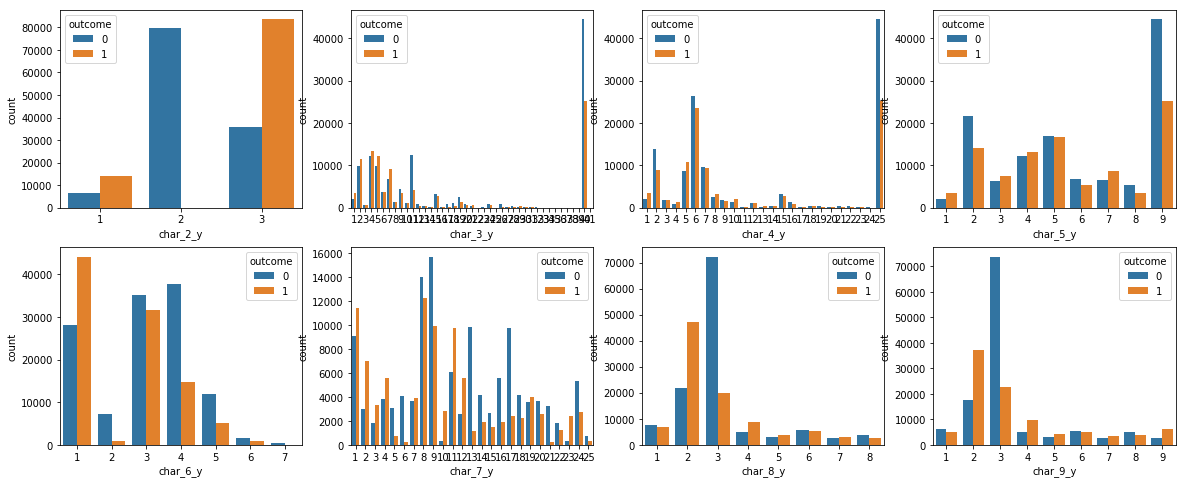

In [123]:
plt.figure(figsize=(20,8))
for i, feat in enumerate(df_sample.columns[-37:-29]):
    plt.subplot(2,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

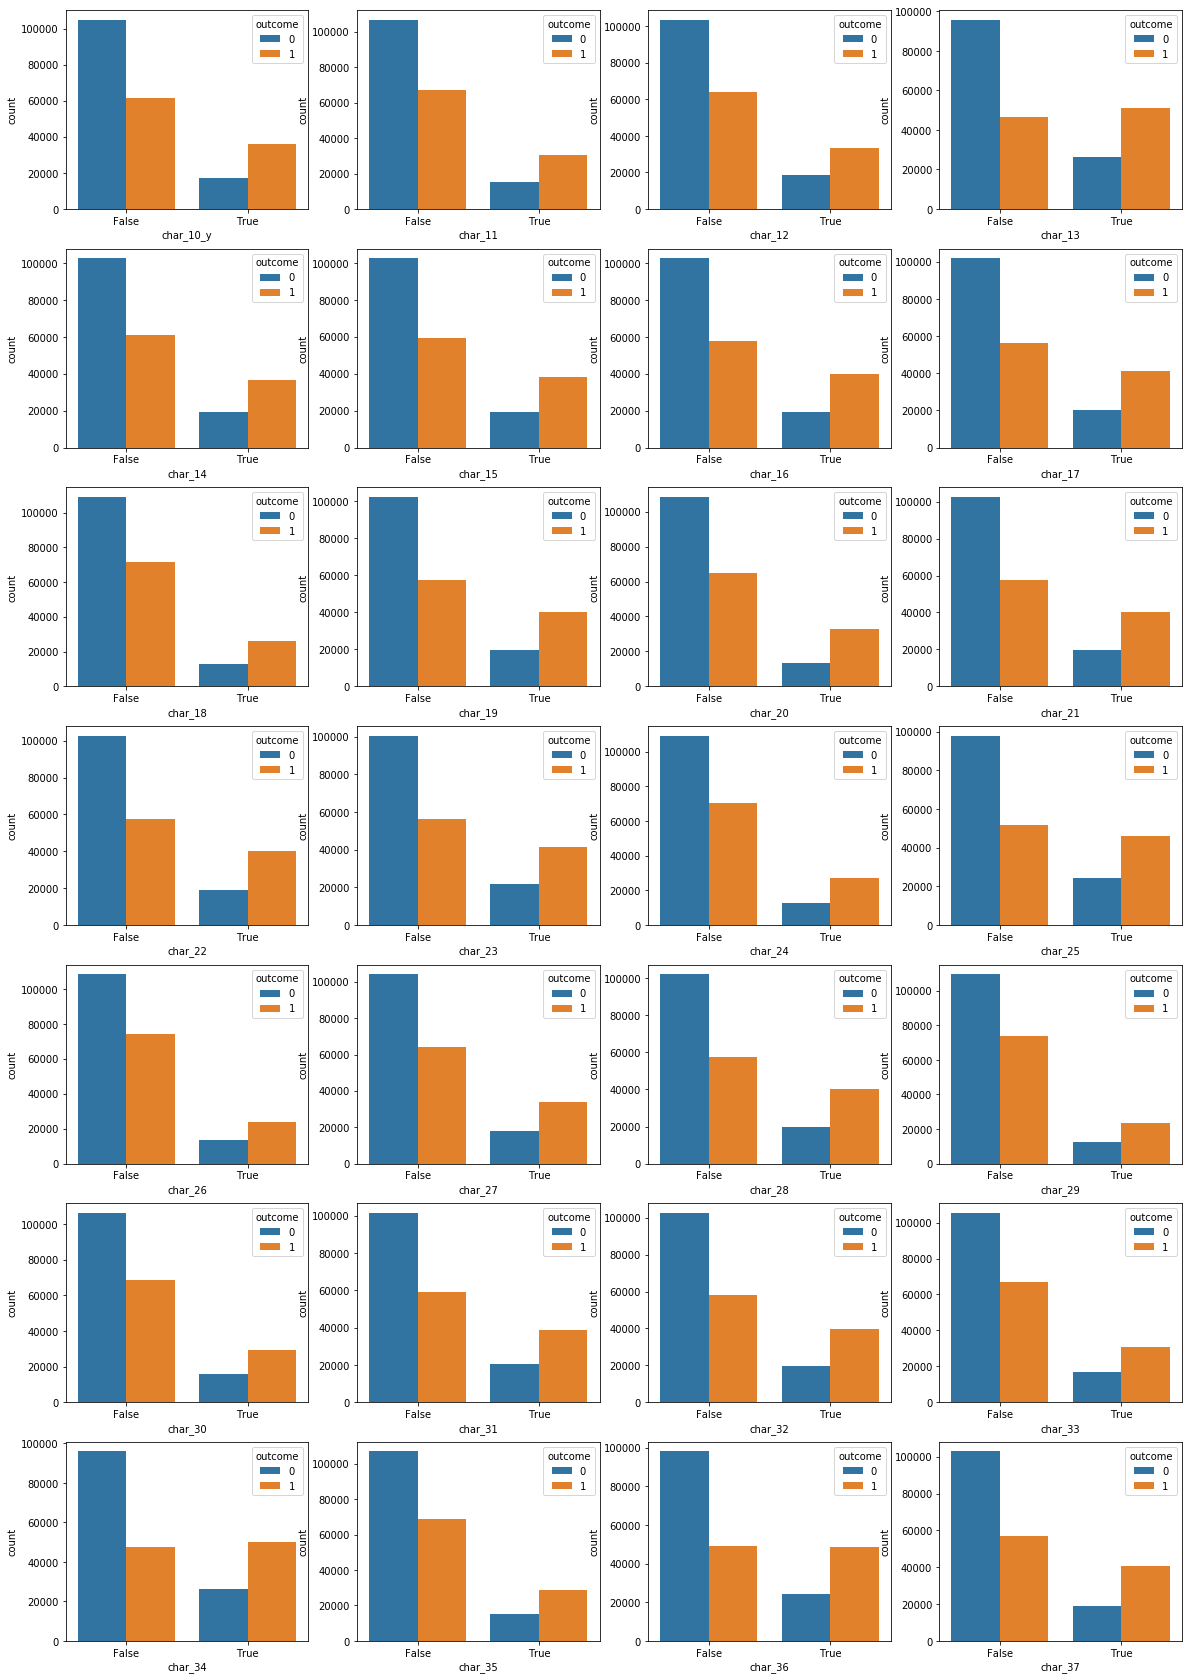

In [82]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[-29:-1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [254]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_sample)
model2 = sm.OLS.from_formula("outcome ~ sum", data=df_sum)

result1 = model1.fit()
result2 = model2.fit()
sm.stats.anova_lm(result1, typ=2)

,sum_sq,df,F,PR(>F)
char_10_y,20.909495,1.0,98.038727,4.148824e-23
char_11,6.475473,1.0,30.361666,3.589448e-08
char_12,3.758204,1.0,17.621158,2.696783e-05
char_13,196.978525,1.0,923.576756,1.940280e-202
char_14,4.203497,1.0,19.709011,9.021898e-06
char_15,42.113315,1.0,197.457460,7.836814e-45
char_16,31.983655,1.0,149.962341,1.813207e-34
char_17,6.847467,1.0,32.105841,1.461796e-08
char_18,5.855156,1.0,27.453177,1.610922e-07
char_19,23.266653,1.0,109.090777,1.571729e-25


In [256]:
sm.stats.anova_lm(model2.fit())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
sum,1.0,5442.363904,5442.363904,24500.224828,0.0
Residual,219727.0,48809.115099,0.222135,NaN,NaN


In [216]:
df_sum = pd.concat([df_sample.iloc[:,-29:-1].sum(axis=1), df_sample['outcome']], axis=1)

In [253]:
df_sum.columns = ['sum', 'outcome']
df_sum.head(3)

,sum,outcome
1990505,9,0
1679895,9,0
1654142,0,0


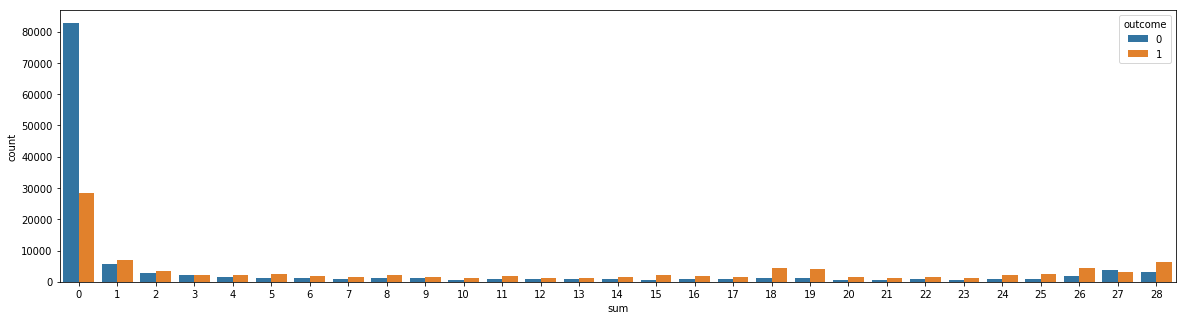

In [224]:
plt.figure(figsize=(20,5))
sns.countplot('sum', hue='outcome', data=df_sum)
plt.show()

#### char_38

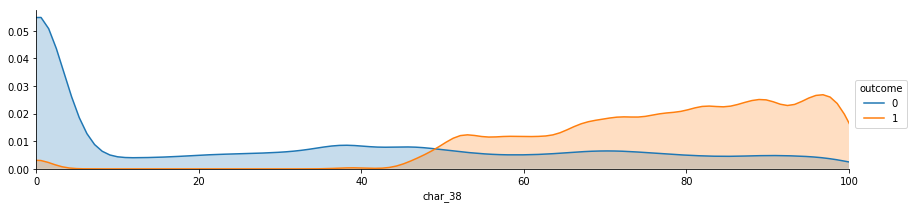

In [143]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

# feature selection

# modeling

In [ ]:
df_tree = df_sample[['activity_category', 'date_x', 'char_38', 'char_1_y', 'char_2_y','outcome']].copy()

In [ ]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=['activity_category', 'char_38', 'char_1_y', 'char_2_y'])
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [ ]:
df_tree_X = df_sample[['activity_category', 'date_x', 'char_1_y', 'char_2_y','char_38']].copy()
df_tree_y = df_sample['outcome'].copy()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_tree_X, df_tree_y)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df_tree_y, tree.predict(df_tree_X))